Here I construct the initial force field Lenard-Jone potential and Coulume potential from UFF and MIL-120 from aiida-plugin

The force field file in RASPA: epsilon units (Kelvin); sigma(Angstrom)

Al_     LENNARD_JONES   254.152 4.0082
C_      LENNARD_JONES   52.8435 3.4309
H_      LENNARD_JONES   22.1439 2.5711
O_      LENNARD_JONES   30.1963 3.1181
O_co2   LENNARD_JONES   79.0    3.05
C_co2   LENNARD_JONES   27.0    2.80

The force field file in OpenMM: epsilon units (KJ/mol); sigma(nm)

Al_     LENNARD_JONES   2.1019    0.40082
C_      LENNARD_JONES   0.4400    0.34309
H_      LENNARD_JONES   0.1841    0.25711
O_      LENNARD_JONES   0.2513    0.31181
O_co2   LENNARD_JONES   0.6577    0.30500
C_co2   LENNARD_JONES   0.2249    0.28000

Some prepared files to run the simulation: (I put all of them in data directory)


It is not easy to generate these files. Bullshit PDB and xml files. I save some childish methods in refine.ipynb to do it. 
If I have time, maybe write new functions to unils.py

Structural file of MOF: 
atoms in pdb file should have a special name

gas.pdb: CO2 molecule predicted by UFF force field
MIL-120.pdb: The rigid framework

A good force field:
custom_force_field.xml, containing charges information from CIF file

In [1]:
# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology
# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading
from utils import cutoff_topology
import matplotlib.pyplot as plt
import optax

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def convert_dict_values_to_str(d):
    for key, value in d.items():
        d[key] = str(value)
    return d

def write_xml(ffinfo, path):
    # Create the root element
    root = ET.Element("ForceField")

    # Create the LennardJonesForce element
    lj_force = ET.SubElement(root, "LennardJonesForce")
    lj_force.set("lj14scale", "0.50000")
    # Add Atom elements for each atom
    for node in ffinfo['Forces']['LennardJonesForce']['node']:
        atom = ET.SubElement(lj_force, node['name'])
        atom.set("epsilon", node['attrib']["epsilon"])
        atom.set("sigma", node['attrib']["sigma"])
        atom.set("type", node['attrib']["type"])
    # Create an ElementTree
    tree = ET.ElementTree(root)

    # Convert the ElementTree to a formatted string with line breaks
    xml_string = minidom.parseString(ET.tostring(root)).toprettyxml(indent="    ")

    # Remove the XML declaration line
    xml_lines = xml_string.split("\n")[1:]

    # Write the formatted XML string to a file
    with open(path, "w") as xml_file:
        xml_file.write("\n".join(xml_lines))

def rewrite_xml(ffinfo, path, origin="custom_forcefield.xml"):
    # Load the XML file
    tree = ET.parse(origin)
    root = tree.getroot()

    # Find the <NonbondedForce> element
    nonbonded_force_element = root.find(".//NonbondedForce")

    # Modify the content of the <NonbondedForce> element
    nonbonded_force_element.clear()  # Remove existing content
    use_attribute_element = ET.SubElement(nonbonded_force_element, "UseAttributeFromResidue", attrib={"name": "charge"})
    use_attribute_element.tail = '\n        '
    for idx, node in enumerate(ffinfo['Forces']['LennardJonesForce']['node']):
        atoms = ET.SubElement(nonbonded_force_element, node['name'], attrib= convert_dict_values_to_str(node['attrib']))
        atoms.tail = '\n        '
    # Add missing attributes to <NonbondedForce>
    nonbonded_force_element.set("coulomb14scale", "0.8333333333333334")
    nonbonded_force_element.set("lj14scale", "0.50")
    # Add <UseAttributeFromResidue name="charge"/>
    
    # Save the modified XML file
    tree.write(path)

In [3]:
"""

Superparameters for Lenard-Jone Potential optimization

"""
particle_number =  500             #液体pdb文件中的分子数
target_site1 = -50.60                  #拟合的目标binding energy
target_site2 = -46.69           #拟合的目标binding energy
SET_temperature=  100           #温度设定
time_gap=   2.2                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   100                  #迭代循环次数    推荐50-100
scaling_factors = (4,4,3)
cutoff = 1.3 #1.3 # unit is nanometer

In [4]:
import openmm.app as app
import openmm as mm
import openmm.unit as unit

def compute_energy(topo, pos, ff, cutoff=cutoff, removeLJ=False):
    global SET_temperature, time_gap
    system = ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=cutoff*unit.nanometer, constraints=None, removeCMMotion=False)
    for force in system.getForces():
        #print(force)
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
            if removeLJ:
                for npart in range(force.getNumParticles()):
                    chrg, sig, eps = force.getParticleParameters(npart)
                    force.setParticleParameters(npart, chrg, 1.0, 0.0)
                for nex in range(force.getNumExceptions()):
                    p1, p2, chrg, sig, eps = force.getExceptionParameters(nex)
                    force.setExceptionParameters(nex, p1, p2, chrg, 1.0, 0.0)
                    #print(nex, p1, p2, chrg, 1.0, 0.0)
    integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, time_gap*unit.femtosecond)
    simulation = app.Simulation(topo, system, integ)
    simulation.context.setPositions(pos)
    state=simulation.context.getState(getEnergy=True)
    potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
    return potential_energy.value_in_unit(unit.kilojoules_per_mole)
    
def binding_energy(topo, positions, ff, cutoff=cutoff, removeLJ=False):
    gas_topo, frame_topo = cutoff_topology(topo)
    total_ener = compute_energy(topo,positions,ff,cutoff=cutoff,removeLJ=removeLJ)
    #print(frame_topo, gas_topo,len(positions[:-3]))
    frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff, removeLJ=removeLJ)
    gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff, removeLJ=removeLJ)
    #print(total_ener,frame_ener,gas_ener)
    print(gas_ener)
    return total_ener-frame_ener-gas_ener

In [66]:
from ase.io import read, write
co2 = read("/home/yutao/project/MIL-120/adsoption/interaction.cif")
print(co2.get_positions())

[[ 4.13272685 -2.97431954  8.34502069]
 [ 3.23378102  3.30204889  8.3380211 ]
 [ 3.15856622  2.14451582  8.3310215 ]
 [-0.37481252  2.91803641  1.15703354]
 [ 3.63365018 -0.80630771  9.99652584]
 [ 3.61710082 -0.81404614  8.83669245]]


In [ ]:
3.633 -0.806  9.996

In [5]:

"""

Test part: Ensure openmm get the same binding energy to the results from raspa

"""

# For site 1

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
add_loading("scaled_frame.pdb","data/gas.pdb","data/site1_supercell.pdb")
pdb = app.PDBFile("data/site1_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

print("This is binding energy:", binding_energy(pdb.topology, pdb.getPositions(),ff))

# For site 2

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
add_loading("scaled_frame.pdb","data/site2.pdb","data/site2_supercell.pdb")
pdb = app.PDBFile("data/site2_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

print("This is binding energy:", binding_energy(pdb.topology, pdb.getPositions(),ff))


0.0028409396135899057
This is binding energy: -58.4100129340613
0.0019603882470567886
This is binding energy: -43.72937127095847


In [6]:

"""

Test part: Ensure openmm get the same binding energy to the results from raspa

"""

# For site 1

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
add_loading("scaled_frame.pdb","data/gas.pdb","data/site1_supercell.pdb")
pdb = app.PDBFile("data/site1_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

print("This is binding energy:", binding_energy(pdb.topology, pdb.getPositions(),ff))

# For site 2

create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
add_loading("scaled_frame.pdb","data/site2.pdb","data/site2_supercell.pdb")
add_loading("data/site2_supercell.pdb","data/gas.pdb","data/new_site2_supercell.pdb")
pdb = app.PDBFile("data/new_site2_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

print("This is binding energy:", binding_energy(pdb.topology, pdb.getPositions(),ff))

0.0028409396135899057
This is binding energy: -58.4100129340613


OpenMMException: Called setPositions() on a Context with the wrong number of positions

In [9]:
gas_ener

-0.9915052852270074

In [61]:
add_loading("scaled_frame.pdb","data/site2.pdb","data/site2_supercell.pdb")
add_loading("data/site2_supercell.pdb","data/site1.pdb","data/new_site2_supercell.pdb")

In [8]:
-104.51183293250828-(-58.845997351857434+-44.32191867274441)

-1.3439169079064328

In [10]:
pdb = app.PDBFile("data/site1_supercell.pdb")
gas_topo, frame_topo = cutoff_topology(pdb.topology)

In [12]:
gas_1 = compute_energy(gas_topo,positions[-6:-3],ff,cutoff=cutoff, removeLJ=False)
gas_2 = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff, removeLJ=False)
print(gas_1+gas_2)

0.004801327860646694


In [11]:
gas_topo

<Topology; 1 chains, 1 residues, 3 atoms, 2 bonds>

In [7]:
pdb = app.PDBFile("data/new_site2_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")
topo = pdb.topology
positions = pdb.getPositions()
gas_topo, frame_topo = cutoff_topology(pdb.topology)
total_ener = compute_energy(topo,positions,ff,cutoff=cutoff,removeLJ=False)
#print(frame_topo, gas_topo,len(positions[:-3]))
frame_ener = compute_energy(frame_topo,positions[:-6],ff,cutoff=cutoff, removeLJ=False)
gas_ener = compute_energy(gas_topo,positions[-6:],ff,cutoff=cutoff, removeLJ=False)
print(total_ener-frame_ener-gas_ener)

-104.51183293250828


In [79]:
gas_ener

305555.01080664684

222791956.675281

In [82]:
origin_arr = np.array([-0.37481252,  2.91803641,  1.15703354])
origin_arr+co2.get_cell()[0]+co2.get_cell()[1]+co2.get_cell()[2]

array([ 2.82642877,  6.63536938, 11.15645921])

In [68]:
pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.angstroms)

(Vec3(x=28.696, y=0.0, z=0.0),
 Vec3(x=-3.293191040716579, y=29.73418821439967, z=0.0),
 Vec3(x=-9.449383653465928, y=-11.147755665122304, z=29.99878086190078))

In [49]:
frame_topo

<Topology; 1 chains, 2 residues, 6 atoms, 4 bonds>

In [ ]:
total_ener = compute_energy(topo,positions,ff,cutoff=cutoff,removeLJ=removeLJ)

In [ ]:
frame_topo, gas_topo = cutoff_topology(topo)
total_ener = compute_energy(topo,positions,ff,cutoff=cutoff,removeLJ=removeLJ)
#print(frame_topo, gas_topo,len(positions[:-3]))
frame_ener = compute_energy(frame_topo,positions[-3:],ff,cutoff=cutoff, removeLJ=removeLJ)
gas_ener = compute_energy(gas_topo,positions[:-3],ff,cutoff=cutoff, removeLJ=removeLJ)
#print(total_ener,frame_ener,gas_ener)
return total_ener-frame_ener-gas_ener

In [6]:
pdb = app.PDBFile("loading_supercell.pdb")
#pdb = app.PDBFile("scaled_frame.pdb")
ff = app.ForceField("custom_forcefield.xml")
gas_topo,frame_topo = cutoff_topology(pdb.topology)
positions = pdb.getPositions()
total_ener = compute_energy(pdb.topology,positions,ff,cutoff=cutoff)-compute_energy(pdb.topology,positions,ff,cutoff=cutoff,removeLJ=True)
#print(frame_topo, gas_topo,len(positions[:-3]))
frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff)-compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff,removeLJ=True)
gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff)-compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff,removeLJ=True)
print(total_ener-frame_ener-gas_ener)
#compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)

-34.438202887773514


In [7]:

def compute_energy_dmff(paramset,topo, pos, lj_gen, cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    #cov_mat = jnp.array(np.zeros((1923,1923)))
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=1920,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

def rerun_dmff(paramset, topo, pos, ffinfo, numframe=1920,cutoff=cutoff):
    lj_gen = LennardJonesGenerator(ffinfo, paramset)
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener


In [8]:
pdb = app.PDBFile("loading_supercell.pdb")
#pdb = app.PDBFile("scaled_frame.pdb")
ff = app.ForceField("test.xml")
gas_topo,frame_topo = cutoff_topology(pdb.topology)
positions = pdb.getPositions()
total_ener = compute_energy(pdb.topology,positions,ff,cutoff=cutoff)-compute_energy(pdb.topology,positions,ff,cutoff=cutoff,removeLJ=True)
#print(frame_topo, gas_topo,len(positions[:-3]))
frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff)-compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff,removeLJ=True)
gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff)-compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff,removeLJ=True)
print(total_ener-frame_ener-gas_ener)
#compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)

-33.29757408797741


In [9]:
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
pdb = app.PDBFile("loading_supercell.pdb")
print(compute_energy_dmff(paramset,pdb.topology, pdb.getPositions(), lj_gen, cutoff=cutoff))
print(compute_binding_energy(paramset,pdb.topology, pdb.getPositions(), lj_gen, numframe=1920,cutoff=cutoff))

223538996.81798586
-33.849178573717126


In [10]:

def run_dmff_lj(topodata, pos,cell, lj_gen, cov_mat, cutoff=cutoff):
    '''
    topodata: dmff.DMFFTopology(topology in openmm)
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"

    cov provide from initialzation
    '''
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(cell.value_in_unit(unit.nanometer))
    nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener


In [11]:
from time import time
dmfftop = dmff.DMFFTopology(pdb.topology)
# Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
topodata = dmfftop
for atom in topodata.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        #print(atom.meta)
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])

cov_mat = dmfftop.buildCovMat()
positions = pdb.getPositions()
t_0 = time()
cov_mat = dmfftop.buildCovMat()
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(positions.value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
cov_mat=cov_mat.at[:1920,:1920].set(1)
nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
nblist.allocate(pos_jnp, cell_jnp)
pairs = jnp.array(nblist.pairs)
print(pairs.shape)
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
print(ener)
print(time()-t_0)


(867500, 3)
-33.849178573717126
0.5504379272460938


In [12]:
from time import time
t_0 = time()

dmfftop = dmff.DMFFTopology(gas_topo)
# Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
topodata = dmfftop
for atom in topodata.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        #print(atom.meta)
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])
cov_mat = dmfftop.buildCovMat()



xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(positions[-3:].value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))

nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
nblist.allocate(pos_jnp, cell_jnp)
pairs = jnp.array(nblist.pairs)
print(pairs.shape)
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)

a = ener
print(time()-t_0)
dmfftop = dmff.DMFFTopology(frame_topo)
# Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
topodata = dmfftop
for atom in topodata.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        #print(atom.meta)
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])
cov_mat = dmfftop.buildCovMat()


xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(positions[:-3].value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))

nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
nblist.allocate(pos_jnp, cell_jnp)
pairs = jnp.array(nblist.pairs)
print(pairs.shape)
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)

b = ener
print(time()-t_0)
dmfftop = dmff.DMFFTopology(pdb.topology)
# Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
topodata = dmfftop
for atom in topodata.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        #print(atom.meta)
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])
cov_mat = dmfftop.buildCovMat()


xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(positions.value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))

nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
nblist.allocate(pos_jnp, cell_jnp)
pairs = jnp.array(nblist.pairs)
print(pairs.shape)
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)

c = ener
print(time()-t_0)


(3, 3)
0.7727549076080322
(864860, 3)
2.566127061843872
(867500, 3)
3.575772762298584


In [13]:
ff = app.ForceField("custom_forcefield.xml")
gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff)-compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff,removeLJ=True)
print(gas_ener-a)

-1.4901161193847656e-08


In [14]:
frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff)-compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff,removeLJ=True)
print(frame_ener-b)

-506.01981699466705


In [15]:
total_ener = compute_energy(pdb.topology,positions,ff,cutoff=cutoff)-compute_energy(pdb.topology,positions,ff,cutoff=cutoff,removeLJ=True)
print(total_ener-c)

-506.6088260412216


In [16]:
pdb = app.PDBFile("scaled_frame.pdb")
frame_topo=pdb.topology
positions=pdb.getPositions()
ff = app.ForceField("custom_forcefield.xml")
frame_ener = compute_energy(frame_topo,positions,ff,cutoff=cutoff)-compute_energy(frame_topo,positions,ff,cutoff=cutoff,removeLJ=True)
reference = compute_energy_dmff(paramset,frame_topo,positions, lj_gen,cutoff=cutoff)
print(frame_ener-reference)
print((frame_ener-reference)/frame_ener)

-506.01981699466705
-2.26368057941225e-06


In [17]:
from time import time
t_0 = time()
cov_mat = dmfftop.buildCovMat()
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
lj_force = lj_gen.createPotential(
    dmfftop, nonbondedMethod=app.CutoffPeriodic, nonbondedCutoff=cutoff, args={})

pos_jnp = jnp.array(positions.value_in_unit(unit.nanometer))
cell_jnp = jnp.array(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
#cov_mat=cov_mat.at[:1920,:1920].set(1)
nblist = NeighborListFreud(pdb.topology.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
nblist.allocate(pos_jnp, cell_jnp)
pairs = jnp.array(nblist.pairs)
print(pairs.shape)
ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
print(ener)
print(time()-t_0)

(864860, 3)
223539030.66716444
0.5734763145446777


In [18]:
pdb = app.PDBFile("process_file/site1-0.pdb")
ff = app.ForceField("custom_forcefield.xml")
system = ff.createSystem(pdb.topology, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False)
for force in system.getForces():
    if isinstance(force, mm.NonbondedForce):
        force.setUseDispersionCorrection(False)
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(pdb.topology, system, integ)
simulation.context.setPositions(pdb.getPositions())
simulation.minimizeEnergy(maxIterations=1000)
simulation.step(100)
final_positions = simulation.context.getState(getPositions=True).getPositions()
initial_positions = pdb.getPositions()
print(np.array(final_positions.value_in_unit(unit.angstrom))-np.array(initial_positions.value_in_unit(unit.angstrom)))

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.05553045 0.03184673 0.18282636]
 [0.09572336 0.0238757  0.11804608]
 [0.14735457 0.02001937 0.09245272]]


In [19]:
pdb = app.PDBFile("process_file/site2-0.pdb")
ff = app.ForceField("custom_forcefield.xml")
system = ff.createSystem(pdb.topology, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False)
for force in system.getForces():
    if isinstance(force, mm.NonbondedForce):
        force.setUseDispersionCorrection(False)
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(pdb.topology, system, integ)
simulation.context.setPositions(pdb.getPositions())
simulation.minimizeEnergy(maxIterations=1000)
simulation.step(100)
final_positions = simulation.context.getState(getPositions=True).getPositions()
initial_positions = pdb.getPositions()
print(np.array(final_positions.value_in_unit(unit.angstrom))-np.array(initial_positions.value_in_unit(unit.angstrom)))

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 ...
 [ 0.09325736 -0.10171751 -0.0332838 ]
 [ 0.06345661 -0.18788157 -0.03183178]
 [ 0.04692647 -0.23482326 -0.03232733]]


In [20]:
print(compute_energy(pdb.topology, initial_positions, ff)-compute_energy(pdb.topology, final_positions, ff))
print(binding_energy(pdb.topology, initial_positions, ff)-binding_energy(pdb.topology, final_positions, ff))

-0.3813706040382385
0.1959277093410492


In [21]:
binding_energy(pdb.topology, final_positions, ff)

-44.51783111691475

In [22]:
SET_temperature=50

In [23]:
def runMD(pdbpath, ff):
    global SET_temperature
    pdb = app.PDBFile(pdbpath)
    system = ff.createSystem(pdb.topology, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False)
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
    integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
    simulation = app.Simulation(pdb.topology, system, integ)
    simulation.context.setPositions(pdb.getPositions())
    simulation.step(20)
    simulation.minimizeEnergy(maxIterations=1000)
    return simulation.context.getState(getPositions=True).getPositions()

In [65]:
site1_pos = app.PDBFile("site1-0.pdb").getPositions()
site2_pos = app.PDBFile("site2-0.pdb").getPositions()
ener_site1 = binding_energy(topodata, site1_pos, ff)
ener_site2 = binding_energy(topodata, site2_pos, ff)
print(ener_site1, ener_site2)

-58.84598591923714 -44.3218919634819


In [66]:
ff = app.ForceField("custom_forcefield.xml")
for loop in range(1, 100):

    #print("Energy Minization on site 1 and 2")
    site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
    site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    print(ener_site1, ener_site2)

-59.40849471092224 -44.73039072751999
-59.28267550468445 -44.82300877571106
-59.47554177045822 -44.57166877388954
-59.289707124233246 -43.44851350784302
-59.498196959495544 -45.01069691777229
-59.47183793783188 -43.230257481336594
-59.47442960739136 -42.7293761074543
-59.464610040187836 -44.82513943314552
-59.349466890096664 -44.54457890987396
-59.312164187431335 -44.70066100358963
-59.37524899840355 -44.387627601623535
-59.465421080589294 -44.761347591876984
-59.4052229821682 -44.698596745729446
-59.34289088845253 -44.32233041524887
-59.28572878241539 -44.44785872101784
-59.19520342350006 -44.63700544834137
-59.34534755349159 -43.3552228808403
-59.34344646334648 -44.6981435418129
-59.193958550691605 -43.38820245862007
-59.55982294678688 -42.76184022426605
-59.408660531044006 -44.94852676987648
-59.28814861178398 -42.762665152549744
-59.41175797581673 -44.32471361756325
-59.168371111154556 -43.57295781373978
-59.4120469391346 -44.94889920949936
-59.19409504532814 -44.76205238699913
-59

KeyboardInterrupt: 

After some tests above, we start to use the lenard Jones potential to optimize the force field parameters

In [24]:
# Initilize structures and force field

site1 = app.PDBFile("data/site1_supercell.pdb")
site2 = app.PDBFile("data/site2_supercell.pdb")
ff = app.ForceField("custom_forcefield.xml")

pdb = app.PDBFile("loading_supercell.pdb")
topodata = pdb.topology

dmfftop = dmff.DMFFTopology(topodata)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
for atom in dmfftop.atoms():
    if atom.residue.name=="MOL":
        atom.meta['type']=atom.meta['element']
        atom.meta['class']=atom.meta['element']
    elif atom.residue.name=="GAS":
        #print(atom.meta)
        atom.meta['type']=atom.meta['element']+"_co2"
        atom.meta['class']=atom.meta['element']+"_co2"
    #print(atom.meta['element'])
cov_mat = dmfftop.buildCovMat()
cov_mat=cov_mat.at[:1920,:1920].set(1)
box = topodata.getPeriodicBoxVectors()

# Some reference value can be used 
pdb = app.PDBFile("scaled_frame.pdb")

#reference_no_lj = binding_energy(pdb.topology, pdb.getPositions(),ff)
#compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)
'''
pdb = app.PDBFile("loading_supercell.pdb")
a = compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)
print(a-reference_no_lj)
'''
print("Initialization finish")

Initialization finish


In [25]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
# Initial optimization tool

import optax
optimizer = optax.adam(0.008)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

In [26]:
def update_mask(parameters, mask):
    updated_parameters = parameters.copy()
    
    for force_type, force_params in mask.items():
        if force_type in parameters:
            for param, mask_array in force_params.items():
                if param in parameters[force_type]:
                    # Update values based on the mask
                    updated_parameters[force_type][param] = jnp.where(mask_array == 1, 
                                                                      parameters[force_type][param], 
                                                                      0)
    return updated_parameters

In [34]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
#paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
# Initial optimization tool

import optax
optimizer = optax.adam(0.001)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

In [27]:
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))

loop_time = 100

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  0.5223006327434234


KeyboardInterrupt: 

In [57]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
# Initial optimization tool

import optax
optimizer = optax.adam(0.008)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

In [27]:
loss_ls0 = []
ener_ls0 = []
params_ls0 = []

In [28]:
import optax
optimizer = optax.adam(0.008)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 2000

#site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
#site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    loss_ls0.append(v)
    ener_ls0.append([ener_site1, ener_site2])
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<4:
        params_ls0.append([v, ener_site1, ener_site2,lj_gen.ffinfo["Forces"][lj_gen.name]["node"]])
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  0.5847694337405756
Error:  0.7767515366183488
Loss: 75.96604810797278
Error:  1.8183366858792027
Error:  1.2311734139283885
Loss: 72.25213309080183
Error:  0.15557718201444715
Error:  0.37253659135609496
Loss: 75.2354433016293
Error:  1.6622121996750536
Error:  0.5016054537111856
Loss: 72.73092402489824
Error:  1.5328467014952736
Error:  0.3815186981886569
Loss: 73.83198916883528
Error:  0.8571727477428865
Error:  1.046792572458557
Loss: 67.65353743743817
Error:  2.5053802023509775
Error:  1.672412327809738
Loss: 69.33341002923787
Error:  1.3648098636608736
Error:  2.280234370558958
Loss: 68.12836854492055
Error:  0.8616454472967234
Error:  -0.7074647216503749
Loss: 66.10909803205055
Error:  1.4497025804125414
Error:  0.5536596967537264
Loss: 64.41037638218147
Error:  1.287840660005557
Error:  0.48083683060238513
Loss: 65.80757601065449
Error:  1.3531130630792703
Error:  1.1048403337636188
Loss: 66.17483516154077
Error:  2.7700242468360443
Error:  1.731072339717457
Loss: 62.810

In [26]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
#paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
# Initial optimization tool

import optax
optimizer = optax.adam(0.008)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

In [27]:
loss_ls1 = []
ener_ls1 = []
params_ls1=[]

In [30]:

#print(paramset.parameters)

path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 500

#site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
#site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    loss_ls1.append(v)
    ener_ls1.append([ener_site1, ener_site2])
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<4:
        params_ls1.append([v, ener_site1, ener_site2,lj_gen.ffinfo["Forces"][lj_gen.name]["node"]])
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  4.070883539952035
Error:  2.9362738708797878
Loss: 61.01198694127254
Error:  1.804314045054241
Error:  1.6419870957464155
Loss: 58.31808081653227
Error:  1.3457515853337014
Error:  -0.7740186209424706
Loss: 59.36930627349669
Error:  1.160592524797032
Error:  0.14534838312142995
Loss: 58.268154784501306
Error:  1.1681029606179152
Error:  0.18881138655257246
Loss: 58.82022927287872
Error:  1.5838199745214467
Error:  0.7199458380272148
Loss: 57.57287287423554
Error:  1.0515108898389798
Error:  0.4808489913626417
Loss: 55.276475132372056
Error:  2.391923977800687
Error:  1.5606696430941867
Loss: 59.63972230702706
Error:  1.3964454052785271
Error:  1.5327202100461221
Loss: 56.92645874653834
Error:  0.7619767605412733
Error:  0.22743206959926
Loss: 54.96198754677576
Error:  2.544760906031648
Error:  2.3177220778908634
Loss: 54.750077572256316
Error:  1.511379219441082
Error:  1.0691239958178969
Loss: 58.853871434453744
Error:  0.9594810177223962
Error:  0.3749341809358242
Loss: 56.97

KeyboardInterrupt: 

In [46]:
print(ener_ls[-5])

[-57.25405478477478, -42.458017110824585]


In [30]:
loss_1_ls = loss_ls0[:]
ener_1_ls = ener_ls0[:]

2000 2000


Text(0.5, 0, 'Cycle number')

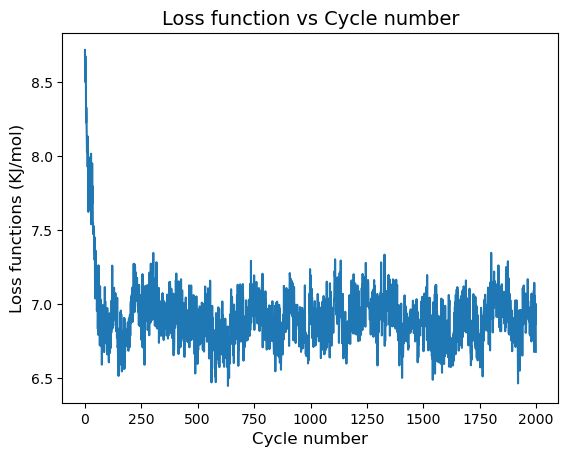

In [31]:
fz = 12
loss_ls = loss_1_ls[:]
ener_ls = ener_1_ls[:]

print(len(loss_ls), len(ener_ls))
plt.plot([np.sqrt(i) for i in loss_ls])
plt.title("Loss function vs Cycle number", fontsize=fz+2)
plt.ylabel("Loss functions (KJ/mol)",fontsize=fz)
plt.xlabel("Cycle number",fontsize=fz)

2000 2000


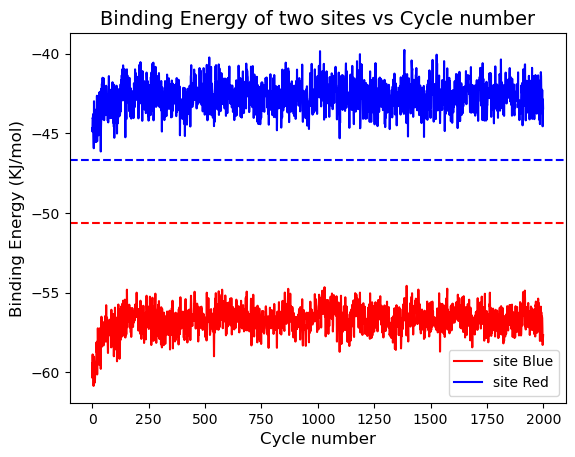

In [34]:
loss_ls = loss_1_ls[:]
ener_ls = ener_1_ls[:]

print(len(loss_ls), len(ener_ls))
plt.plot([i[0] for i in ener_ls], color="red",label="site Blue")
plt.plot([i[1] for i in ener_ls], color='blue',label="site Red")
# Add horizontal lines
plt.axhline(y=target_site1, color='red', linestyle='--')
plt.axhline(y=target_site2, color='blue', linestyle='--')
plt.ylabel("Binding Energy (KJ/mol)",fontsize=fz)
plt.xlabel("Cycle number",fontsize=fz)
plt.title("Binding Energy of two sites vs Cycle number", fontsize=fz+2)
plt.legend()

In [33]:
loss_2_ls = loss_ls1[:]
ener_2_ls = ener_ls1[:]

232 232


Text(0.5, 0, 'Cycle number')

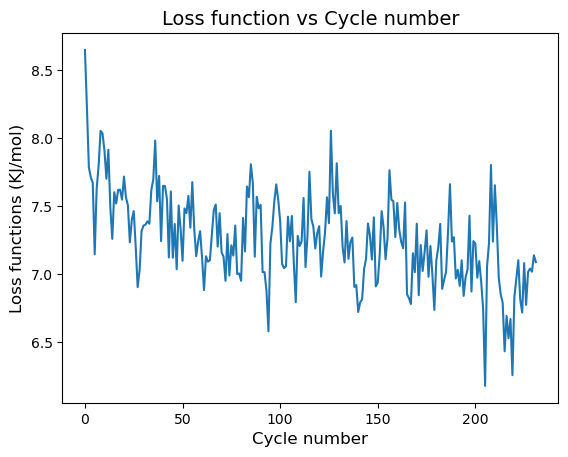

In [79]:
fz = 12
loss_ls = loss_1_ls[:]
ener_ls = ener_1_ls[:]

print(len(loss_ls), len(ener_ls))
plt.plot([np.sqrt(i) for i in loss_ls])
plt.title("Loss function vs Cycle number", fontsize=fz+2)
plt.ylabel("Loss functions (KJ/mol)",fontsize=fz)
plt.xlabel("Cycle number",fontsize=fz)

232 232


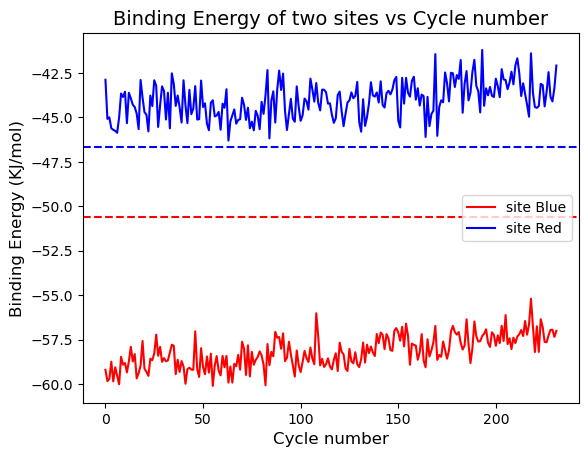

In [80]:
loss_ls = loss_1_ls[:]
ener_ls = ener_1_ls[:]

print(len(loss_ls), len(ener_ls))
plt.plot([i[0] for i in ener_ls], color="red",label="site Blue")
plt.plot([i[1] for i in ener_ls], color='blue',label="site Red")
# Add horizontal lines
plt.axhline(y=target_site1, color='red', linestyle='--')
plt.axhline(y=target_site2, color='blue', linestyle='--')
plt.ylabel("Binding Energy (KJ/mol)",fontsize=fz)
plt.xlabel("Cycle number",fontsize=fz)
plt.title("Binding Energy of two sites vs Cycle number", fontsize=fz+2)
plt.legend()

346 346


Text(0.5, 0, 'Cycle number')

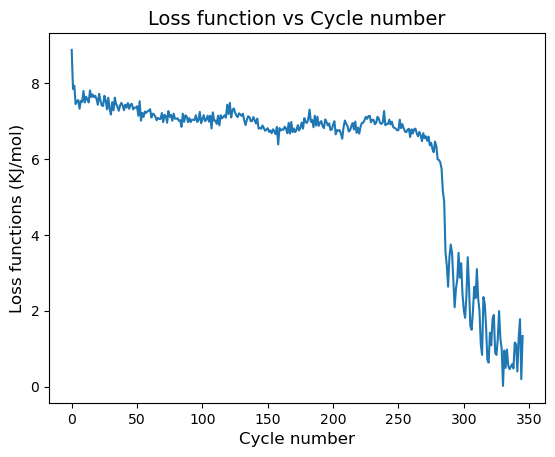

In [34]:
fz = 12
loss_ls = loss_2_ls[:]
ener_ls = ener_2_ls[:]

print(len(loss_ls), len(ener_ls))
plt.plot([np.sqrt(i) for i in loss_ls])
plt.title("Loss function vs Cycle number", fontsize=fz+2)
plt.ylabel("Loss functions (KJ/mol)",fontsize=fz)
plt.xlabel("Cycle number",fontsize=fz)

346 346


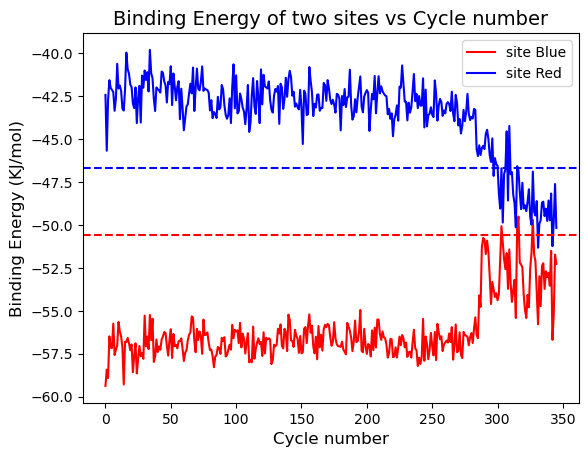

In [35]:
loss_ls = loss_2_ls[:]
ener_ls = ener_2_ls[:]

print(len(loss_ls), len(ener_ls))
plt.plot([i[0] for i in ener_ls], color="red",label="site Blue")
plt.plot([i[1] for i in ener_ls], color='blue',label="site Red")
# Add horizontal lines
plt.axhline(y=target_site1, color='red', linestyle='--')
plt.axhline(y=target_site2, color='blue', linestyle='--')
plt.ylabel("Binding Energy (KJ/mol)",fontsize=fz)
plt.xlabel("Cycle number",fontsize=fz)
plt.title("Binding Energy of two sites vs Cycle number", fontsize=fz+2)
plt.legend()

In [29]:
print(ener_site1,ener_site2)
print(paramset.parameters)
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

-56.13679292798042 -42.13830775022507
{'LennardJonesForce': {'epsilon': Array([2.05768074, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
       0.22469   ], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.3547711, 0.34309  , 0.25711  , 0.31181  , 0.305    , 0.28     ],      dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}
Error:  -54.85780200996204
Error:  -40.52921607602615


In [40]:
print(ener_site1,ener_site2)
print(paramset.parameters)
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

-55.651949852705 -42.92072430253029
{'LennardJonesForce': {'epsilon': Array([1.71981396, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
       0.22469   ], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}
Error:  -55.66002789513662
Error:  -42.75266434304113


In [59]:
import optax
optimizer = optax.adam(0.03)
opt_state = optimizer.init(paramset)
#print(paramset.parameters)

path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 500

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    loss_ls0.append(v)
    ener_ls0.append([ener_site1, ener_site2])
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<40:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

KeyboardInterrupt: 

In [54]:
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)

Error:  0.5181541676505361
Error:  -0.4729582754034567


In [57]:
ener_site1 = binding_energy(topodata, site1_pos, ff)
ener_site2 = binding_energy(topodata, site2_pos, ff)
print(ener_site1, ener_site2)

-57.40719825029373 -42.31727132201195


In [53]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([1.69214738, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
         0.22469   ], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [52]:
print(ener_site1, ener_site2)

-57.257406800985336 -42.06769406795502


32 32


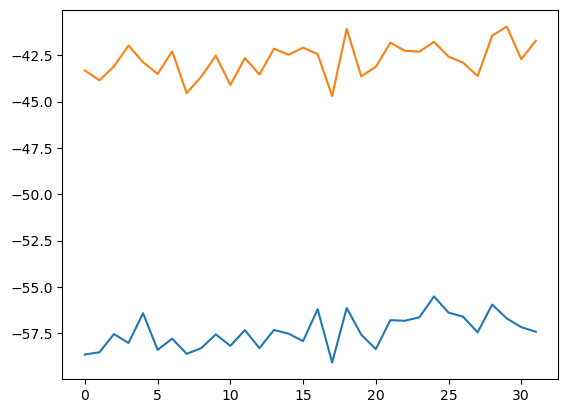

In [60]:
loss_ls = loss_ls0[:]
ener_ls = ener_ls0[:]

print(len(loss_ls), len(ener_ls))
plt.plot([i[0] for i in ener_ls])
plt.plot([i[1] for i in ener_ls])

In [32]:
loss_ls = loss_ls0[:]
ener_ls = ener_ls0[:]

print(len(loss_ls), len(ener_ls))
plt.plot([i[0] for i in ener_ls])
plt.plot([i[1] for i in ener_ls])

-55.651949852705 -42.92072430253029
{'LennardJonesForce': {'epsilon': Array([1.71981396, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
       0.22469   ], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [30]:
print(ener_site1,ener_site2)
print(paramset.parameters)

-53.68930068612099 -43.64450052380562
{'LennardJonesForce': {'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64), 'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64), 'sigma_nbfix': Array([], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64)}}


In [35]:
print(ener_site1,ener_site2)
print(paramset.parameters)

-54.7140206694603 -41.67841151356697
{'LennardJonesForce': {'epsilon': Array([1.94972618, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
       0.22469   ], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.40701473, 0.34309   , 0.25711   , 0.31181   , 0.305     ,
       0.28      ], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [30]:
updates.parameters

{'LennardJonesForce': {'epsilon': Array([-0.00230479,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([-0.00034524,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [26]:
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 100

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  0.6988361797228748
Error:  1.1823140822115903
Loss: 50.060083135699344
Error:  1.72148863094192
Error:  1.7651882587314773
Loss: 49.946148796267266
Error:  1.244167269810383
Error:  0.39499847715251235
Loss: 49.83402560004298
Error:  1.2043851811519062
Error:  1.8060607615608504
Loss: 49.72365992532363
Error:  2.00835930885421
Error:  1.6702788588381594
Loss: 49.61488192179671
Error:  0.5936134342739052
Error:  2.0970102874681658
Loss: 49.50803996360281
Error:  0.05385667562845953
Error:  0.08625282284292268
Loss: 49.40307849427896
Error:  1.3891239316799755
Error:  -0.612030348392075
Loss: 49.29974918707221
Error:  1.0681161434203972
Error:  1.127219341510397
Loss: 49.198634093678095
Error:  1.934591249931799
Error:  1.4758053458410103
Loss: 49.0994028741397
Error:  2.7385609742415653
Error:  3.027501529133133
Loss: 49.0018361618095
Error:  1.2925061816509498
Error:  1.7979184190028832
Loss: 48.90644876780841
Error:  2.9089038794938347
Error:  2.7714431265044936
Loss: 48.81310

In [29]:
optimizer = optax.adam(0.02)
opt_state = optimizer.init(paramset)

In [27]:
loss_ls = []
error_ls = []

In [28]:
optimizer = optax.adam(0.005)
opt_state = optimizer.init(paramset)
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)


os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 1000

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    error1 = compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1
    error2 = compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2
    print("Error: ", error1)
    print("Error: ", error2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    loss_ls.append(v)
    error_ls.append([error1,error2])
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  0.6714166523988752
Error:  -0.4474044010228937
Loss: 59.77094523604964
Error:  2.623007763307541
Error:  1.3309933564616259
Loss: 59.682767866355356
Error:  1.699620542137822
Error:  1.2344038355955433
Loss: 59.59511650492204
Error:  2.4012341520279676
Error:  1.2159466237187928
Loss: 59.50827585674918
Error:  0.6653582458337155
Error:  0.5412526972136362
Loss: 59.42197599339347
Error:  0.2732677077130603
Error:  -0.16468327262513327
Loss: 59.336372223569995
Error:  1.2561572952097464
Error:  1.1918982703726044
Loss: 59.25153585030482
Error:  1.520313301816529
Error:  1.1109652929264726
Loss: 59.16721836544349
Error:  2.1282109706239467
Error:  2.9831715893813566
Loss: 59.083782454074374
Error:  1.6736289462146487
Error:  0.9647349001557046
Loss: 59.00084914147847
Error:  1.2502733811704871
Error:  0.649449337463686
Loss: 58.918899595460886
Error:  0.23316909604529457
Error:  -0.8064749663247
Loss: 58.83759451219896
Error:  0.9348294655103899
Error:  -0.4811494597993047
Loss: 5

In [29]:
optimizer = optax.adam(0.018)
opt_state = optimizer.init(paramset)
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)


os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 1000

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    error1 = compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1
    error2 = compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2
    print("Error: ", error1)
    print("Error: ", error2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    loss_ls.append(v)
    error_ls.append([error1,error2])
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  2.144307977565795
Error:  1.483641916704265
Loss: 42.978437393090516
Error:  1.6520689437514235
Error:  0.6177044384591213
Loss: 42.80680151572248
Error:  1.0977967725480937
Error:  0.6115903004974115
Loss: 42.64809525581934
Error:  2.5440670308059694
Error:  1.3404070761363727
Loss: 42.50239094304596
Error:  1.147247240388424
Error:  1.0073527301680585
Loss: 42.3694810273407
Error:  0.9074511446286522
Error:  -0.6218061970674142
Loss: 42.24938717059673
Error:  2.07482287513222
Error:  0.3280334372796432
Loss: 42.1416347970138
Error:  1.211945282279082
Error:  1.3101107102148077
Loss: 42.046189185437555
Error:  1.7252229828306724
Error:  1.3245692933185893
Loss: 41.962304764174085
Error:  0.2710550541460748
Error:  0.30905510210428844
Loss: 41.88997020288362
Error:  1.193337946000824
Error:  0.7324495067101964
Loss: 41.82814189162919
Error:  0.46097907576549346
Error:  -0.21760533928325287
Loss: 41.776581507731365
Error:  1.855356520422177
Error:  0.6309285774095272
Loss: 41.73

KeyboardInterrupt: 

In [ ]:
optimizer = optax.adam(0.018)
opt_state = optimizer.init(paramset)
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)


os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 1000

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    error1 = compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1
    error2 = compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2
    print("Error: ", error1)
    print("Error: ", error2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    loss_ls.append(v)
    error_ls.append([error1,error2])
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

In [31]:
optimizer = optax.adam(0.03)
opt_state = optimizer.init(paramset)
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 100

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

for nloop in range(1, loop_time+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    #print(paramset.mask)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  1.1503729867050652
Error:  0.048244870297352804
Loss: 53.25438693521793
Error:  1.490512120860771
Error:  0.39554917188915795
Loss: 53.04712170312666
Error:  1.3933567279978405
Error:  0.336810428529418
Loss: 52.86911949305299
Error:  1.0146854344185954
Error:  -0.3315546781916723
Loss: 52.721103601756525
Error:  0.041291918758886936
Error:  -1.6101651113263458
Loss: 52.60414438533793
Error:  1.7222941631409867
Error:  0.7032659975049427
Loss: 52.51720977478918
Error:  0.9626971040569146
Error:  -0.7517204888327385
Loss: 52.45979504227619
Error:  -0.2701801009348159
Error:  -0.6170533605680006
Loss: 52.42927236153419
Error:  1.2719126650204515
Error:  0.8244217035711614
Loss: 52.42166707000175
Error:  2.1183984417851462
Error:  1.5710396785328626
Loss: 52.43126721134212
Error:  2.0175024881681978
Error:  0.027451092682497347
Loss: 52.45145297869685
Error:  1.4678699627642544
Error:  -0.08882798910082101
Loss: 52.47558743408297
Error:  1.2499710608176855
Error:  1.01838790329853

In [32]:
print(ener_site1,ener_site2)
print(paramset.parameters)

-55.11214831471443 -42.605300307273865
{'LennardJonesForce': {'epsilon': Array([1.8614317, 0.43979  , 0.18436  , 0.25079  , 0.65757  , 0.22469  ],      dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [35]:
print(ener_site1,ener_site2)
print(paramset.parameters)

-56.43994715809822 -43.55597683787346
{'LennardJonesForce': {'epsilon': Array([2.52969352, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
       0.22469   ], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [30]:
print(ener_site1,ener_site2)
print(paramset.parameters)

-56.358377903699875 -43.33954527974129
{'LennardJonesForce': {'epsilon': Array([1.83134577, 0.43979   , 0.18436   , 0.25079   , 0.65757   ,
       0.22469   ], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [35]:
for nloop in range(1, 20+1):
    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
    #site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters

    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    if v<2:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  6.041683048893496
Error:  -5.335105977110999
Loss: 0.23873661499090026
[{'name': 'Atom', 'attrib': {'epsilon': '0.8521059035634801', 'sigma': '0.5949322415601603', 'type': 'Al'}}, {'name': 'Atom', 'attrib': {'epsilon': '0.43979', 'sigma': '0.34309', 'type': 'C', 'mask': 'True'}}, {'name': 'Atom', 'attrib': {'epsilon': '0.18436', 'sigma': '0.25711', 'type': 'H', 'mask': 'true'}}, {'name': 'Atom', 'attrib': {'epsilon': '0.25079', 'sigma': '0.31181', 'type': 'O', 'mask': 'true'}}, {'name': 'Atom', 'attrib': {'epsilon': '0.65757', 'sigma': '0.305', 'type': 'O_co2', 'mask': 'true'}}, {'name': 'Atom', 'attrib': {'epsilon': '0.22469', 'sigma': '0.28', 'type': 'C_co2', 'mask': 'true'}}]
-47.34038531014456
-46.80813470089378
Error:  2.9054464178370054
Error:  4.352152321696856
Loss: 10.639042832594948
Error:  2.6769619982518194
Error:  2.5736249627480277
Loss: 11.8173039333139
Error:  3.6559575193448524
Error:  3.1294604430488704
Loss: 4.305173072827947
Error:  2.355830308449555
Error: 

In [29]:
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 100

site1_pos = runMD(os.path.join(path,f"site1-0.pdb"),ff)
site2_pos = runMD(os.path.join(path,f"site2-0.pdb"),ff)

nloop = 1

xmlio = XMLIO()
xmlio.loadXML(os.path.join(path,f"try-{nloop-1}.xml"))
ffinfo = xmlio.parseXML()
paramset0 = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset0)


ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
#print("Energy Minization on site 1 and 2")
#site1_pos = runMD(os.path.join(path,f"site1-{nloop-1}.pdb"),ff)
#site2_pos = runMD(os.path.join(path,f"site2-{nloop-1}.pdb"),ff)
# compute binding Energy
ener_site1 = binding_energy(topodata, site1_pos, ff)
ener_site2 = binding_energy(topodata, site2_pos, ff)
refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
print("This is right value:",ener_site1,ener_site2)
print("This is wrong value:")
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
def loss(params):
    error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
    error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
    return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)
print("Loss:", v)
    
# update parameters
updates, opt_state = optimizer.update(g, opt_state)
updates.parameters = update_mask(updates.parameters,paramset.mask)
paramset = optax.apply_updates(paramset, updates)
paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
# upate ffinfo



This is right value: -56.469220370054245 -44.50552251935005
This is wrong value:
Error:  -56.05397410938462
Error:  -43.60859229703843
Loss: 39.24090701770863


In [ ]:
lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
#write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
write_xml(lj_gen.ffinfo, os.path.join(path,f"try-{nloop}.xml"))
if (ener_site1-target_site1)**2+(ener_site2-target_site2)**2<2:
    print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

In [21]:
ener_site1 = binding_energy(topodata, site1_pos, ff)
ener_site2 = binding_energy(topodata, site2_pos, ff)

print(ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site2)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

-56.212047308683395
Error:  -50.8722210727806
-43.445243418216705
Error:  -46.605650793172465


In [37]:
lj_gen.ffinfo["Forces"]["LennardJonesForce"]

{'meta': {'lj14scale': '1.0'},
 'node': [{'name': 'Atom',
   'attrib': {'epsilon': '2.1677228043828407',
    'sigma': '0.40082',
    'type': 'Al'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.43979',
    'sigma': '0.34309',
    'type': 'C',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.18436',
    'sigma': '0.25711',
    'type': 'H',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.25079',
    'sigma': '0.31181',
    'type': 'O',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.65757',
    'sigma': '0.305',
    'type': 'O_co2',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.22469',
    'sigma': '0.28',
    'type': 'C_co2',
    'mask': 'True'}}]}

In [23]:
rewrite_xml(lj_gen.ffinfo, "test.xml")
write_xml(lj_gen.ffinfo, "try.xml")

In [34]:
xmlio = XMLIO()
xmlio.loadXML("try.xml")
ffinfo = xmlio.parseXML()
paramset1 = ParamSet()
lj_gen_new = LennardJonesGenerator(ffinfo, paramset1)


pdb = app.PDBFile("loading_supercell.pdb")
positions = pdb.getPositions()

ff_new = app.ForceField("test.xml")
ener_site1 = binding_energy(topodata, positions, ff_new)
refer_site1 = binding_energy(topodata, positions, ff, removeLJ=True)

print(ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, positions, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site1)

-43.181274592876434
Error:  -46.0129148008374


In [35]:
ff_new = app.ForceField("test.xml")
ener_site1 = binding_energy(topodata, site1_pos, ff_new)
ener_site2 = binding_energy(topodata, site2_pos, ff_new)
refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
print(ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site2)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site2)

-56.212035804986954
Error:  -50.87222488747786
-43.44524723291397
Error:  -46.60565460786973


In [ ]:
xmlio = XMLIO()
xmlio.loadXML("try.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
pdb = app.PDBFile("loading_supercell.pdb")
positions = pdb.getPositions()
print(compute_energy_dmff(paramset,pdb.topology, positions, lj_gen, cutoff=cutoff))
print(compute_binding_energy(paramset,pdb.topology, positions, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)

pdb = app.PDBFile("loading_supercell.pdb")
#pdb = app.PDBFile("scaled_frame.pdb")
ff = app.ForceField("test.xml")
gas_topo,frame_topo = cutoff_topology(pdb.topology)
#
total_ener = compute_energy(pdb.topology,positions,ff,cutoff=cutoff)-compute_energy(pdb.topology,positions,ff,cutoff=cutoff,removeLJ=True)
#print(frame_topo, gas_topo,len(positions[:-3]))
frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff)-compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff,removeLJ=True)
gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff)-compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff,removeLJ=True)
print(total_ener-frame_ener-gas_ener+refer_site1)
#compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)

In [24]:
xmlio = XMLIO()
xmlio.loadXML("try.xml")
ffinfo = xmlio.parseXML()
paramset1 = ParamSet()
lj_gen_new = LennardJonesGenerator(ffinfo, paramset1)


In [25]:
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  -50.8722210727806
Error:  -46.605650793172465


In [26]:
ener_site1 = binding_energy(topodata, site1_pos, ff)
ener_site2 = binding_energy(topodata, site2_pos, ff)
print(ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site2)
print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

-57.9048912525177
Error:  -50.31391092109311
-43.13500517606735
Error:  -46.991100203105056


In [37]:
cutoff

1.3

In [51]:
new_cutoff = 1.43

red_pos = app.PDBFile("data/site1_supercell.pdb").getPositions()
blue_pos = app.PDBFile("data/site2_supercell.pdb").getPositions()
ener_site1 = binding_energy(topodata, red_pos, ff, cutoff=new_cutoff)
ener_site2 = binding_energy(topodata, blue_pos , ff, cutoff=new_cutoff)
refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True, cutoff=new_cutoff)
refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True, cutoff=new_cutoff)
print(ener_site1)
print("Error: ",compute_binding_energy(paramset,topodata, red_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site2)
print("Error: ",compute_binding_energy(paramset,topodata, blue_pos , lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

-57.44171646237373
Error:  -48.776552224522945
-46.64840218424797
Error:  -48.868623750105264


In [47]:
binding_energy(topodata, blue_pos , ff,cutoff=1.43)

-46.6484098136425

In [41]:
print("Error: ",compute_binding_energy(paramset,topodata, blue_pos , lj_gen, numframe=1920,cutoff=1.3)+refer_site2)

Error:  -46.81985239107883


In [53]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([2.10573633, 0.41736552, 0.15523719, 0.25992135, 0.6451942 ,
         0.20264864], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.39790579, 0.34734142, 0.21442431, 0.36739237, 0.28080769,
         0.28046279], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [35]:
for num in range(45,50):
    red_pos = app.PDBFile(os.path.join(path,f"site1-{num}.pdb")).getPositions()
    blue_pos = app.PDBFile(os.path.join(path,f"site2-{num}.pdb")).getPositions()
    ener_site1 = binding_energy(topodata, red_pos, ff)
    ener_site2 = binding_energy(topodata, blue_pos , ff)
    print(ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, red_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
    print(ener_site2)
    print("Error: ",compute_binding_energy(paramset,topodata, blue_pos , lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

-57.84195628762245
Error:  -50.30959728557804
-43.07255160808563
Error:  -46.99055610645759
-57.84196773171425
Error:  -50.30959728557804
-43.07254779338837
Error:  -46.99055610645759
-57.84197536110878
Error:  -50.30959728557804
-43.07255160808563
Error:  -46.99055610645759
-57.84197536110878
Error:  -50.30959728557804
-43.07254013419151
Error:  -46.99055610645759
-57.841971546411514
Error:  -50.30959728557804
-43.0725439786911
Error:  -46.99055610645759


In [41]:
path = "process_file/"
if not os.path.exists(path):
    os.makedirs(path)

os.system("cp data/site1_supercell.pdb "+os.path.join(path,"site1-0.pdb"))
os.system("cp data/site2_supercell.pdb "+os.path.join(path,"site2-0.pdb"))
os.system("cp data/custom_forcefield.xml "+os.path.join(path,"init-0.xml"))
os.system("cp data/init.xml "+os.path.join(path,f"try-0.xml"))
loop_time = 100


for nloop in range(1, loop_time+1):
    '''
    xmlio = XMLIO()
    xmlio.loadXML(os.path.join(path,f"try-{nloop-1}.xml"))
    ffinfo = xmlio.parseXML()
    paramset = ParamSet()
    lj_gen = LennardJonesGenerator(ffinfo, paramset)
    '''

    ff = app.ForceField(os.path.join(path,f"init-{nloop-1}.xml"))
    #print("Energy Minization on site 1 and 2")
    site1_pos = app.PDBFile(os.path.join(path,"site1-0.pdb")).getPositions()
    site2_pos = app.PDBFile(os.path.join(path,"site2-0.pdb")).getPositions()
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print("Error: ",compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1)
    print("Error: ",compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-ener_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters
    updates, opt_state = optimizer.update(g, opt_state)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update
    #write_xml(lj_gen, os.path.join(path, f"init-{nloop}.pdb"))    
    app.PDBFile.writeFile(topodata, site1_pos, open(os.path.join(path,f"site1-{nloop}.pdb"), 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(os.path.join(path,f"site2-{nloop}.pdb"), 'w'))
    rewrite_xml(lj_gen.ffinfo, os.path.join(path,f"init-{nloop}.xml"), os.path.join(path,f"init-{nloop-1}.xml"))
    write_xml(lj_gen.ffinfo, os.path.join(path,f"try-{nloop}.xml"))
    if v<3:
        print(lj_gen.ffinfo["Forces"][lj_gen.name]["node"])
        print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
        print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)

Error:  1.8084089861938537
Error:  1.1138807676419162
Loss: 53.56661221970735


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [35]:
xmlio = XMLIO()
xmlio.loadXML(f"try.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen_new = LennardJonesGenerator(ffinfo, paramset)

In [28]:
write_xml(lj_gen.ffinfo, "try.xml")

In [40]:
frame_topo

<Topology; 1 chains, 48 residues, 1920 atoms, 0 bonds>

In [41]:
gas_topo

<Topology; 1 chains, 1 residues, 3 atoms, 2 bonds>

In [42]:
len(site1_pos)

1923

In [45]:
compute_energy_dmff(paramset,topodata, site1_pos, lj_gen,cutoff=cutoff)-compute_energy_dmff(paramset,frame_topo,positions, lj_gen,cutoff=cutoff)+refer_site1

Array(-56.76027128, dtype=float64)

In [53]:
lj_gen.ffinfo["Forces"]['LennardJonesForce']

{'meta': {'lj14scale': '1.0'},
 'node': [{'name': 'Atom',
   'attrib': {'epsilon': '2.1086606711002744',
    'sigma': '0.40082',
    'type': 'Al'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.43979',
    'sigma': '0.34309',
    'type': 'C',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.18436',
    'sigma': '0.25711',
    'type': 'H',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.25079',
    'sigma': '0.31181',
    'type': 'O',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.65757',
    'sigma': '0.305',
    'type': 'O_co2',
    'mask': 'True'}},
  {'name': 'Atom',
   'attrib': {'epsilon': '0.22469',
    'sigma': '0.28',
    'type': 'C_co2',
    'mask': 'True'}}]}

In [36]:
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site1)
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)

-56.76027127319406
-56.76027127319406


In [48]:
ff = app.ForceField("test.xml")
ener_site1 = binding_energy(topodata, site1_pos, ff)
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen_new, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site1)

-56.76027127319406
-59.27182728052139


In [26]:
compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-ener_site1

Array(8.17056114, dtype=float64)

In [38]:
ener_site1 = binding_energy(topodata, site1_pos, ff)
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site1)

-56.76027127319406
-59.27182728052139


In [39]:
rewrite_xml(lj_gen.ffinfo, "test.xml")
ff = app.ForceField("test.xml")
ener_site1 = binding_energy(topodata, site1_pos, ff)
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site1)

-56.76027127319406
-59.27183109521866


In [39]:
rewrite_xml(lj_gen.ffinfo, "test.xml")
ff = app.ForceField("test.xml")
ener_site1 = binding_energy(topodata, site1_pos, ff)
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(ener_site1)

-57.744442912871484
-58.64385426044464


In [41]:
type(lj_gen)

dmff.generators.classical.LennardJonesGenerator

In [40]:
lj_gen.ffinfo

{'Operators': {},
 'AtomTypes': [],
 'Residues': [],
 'Forces': {'LennardJonesForce': {'meta': {'lj14scale': '1.0'},
   'node': [{'name': 'Atom',
     'attrib': {'epsilon': '2.11525', 'sigma': '0.40082', 'type': 'Al'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.43979',
      'sigma': '0.34309',
      'type': 'C',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.18436',
      'sigma': '0.25711',
      'type': 'H',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.25079',
      'sigma': '0.31181',
      'type': 'O',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.65757',
      'sigma': '0.305',
      'type': 'O_co2',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.22469',
      'sigma': '0.28',
      'type': 'C_co2',
      'mask': 'True'}}]}},
 'ClassToType': {}}

In [35]:
lj_gen.ffinfo

{'Operators': {},
 'AtomTypes': [],
 'Residues': [],
 'Forces': {'LennardJonesForce': {'meta': {'lj14scale': '1.0'},
   'node': [{'name': 'Atom',
     'attrib': {'epsilon': '2.101736951285485',
      'sigma': '0.40082',
      'type': 'Al'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.43979',
      'sigma': '0.34309',
      'type': 'C',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.18436',
      'sigma': '0.25711',
      'type': 'H',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.25079',
      'sigma': '0.31181',
      'type': 'O',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.65757',
      'sigma': '0.305',
      'type': 'O_co2',
      'mask': 'True'}},
    {'name': 'Atom',
     'attrib': {'epsilon': '0.22469',
      'sigma': '0.28',
      'type': 'C_co2',
      'mask': 'True'}}]}},
 'ClassToType': {}}

In [31]:
compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)

Array(-35.63334149, dtype=float64)

In [27]:
compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1

Array(-50.87954309, dtype=float64)

In [39]:
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
ff = app.ForceField("custom_forcefield.xml")

In [48]:
ff = app.ForceField("custom_forcefield.xml")
os.system("cp data/site1_supercell.pdb site1-0.pdb")
os.system("cp data/site2_supercell.pdb site2-0.pdb")
for nloop in range(1, loop_time+1):

    #print("Energy Minization on site 1 and 2")
    site1_pos = app.PDBFile("site1-0.pdb").getPositions()
    site2_pos = app.PDBFile("site2-0.pdb").getPositions()
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print(f"Binding Energy: {ener_site1}(LJ) {target_site1} (DFT)")
    print(f"Binding Energy: {ener_site2}(LJ) {target_site2} (DFT)")
    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2)
    break

Binding Energy: -58.845978289842606(LJ) -50.6 (DFT)
Binding Energy: -44.321899592876434(LJ) -46.69 (DFT)
-58.02718321172436
-43.732898181788386
-7.427183211724362
2.957101818211612


In [47]:
rewrite_xml(lj_gen.ffinfo, "test.xml")
ff = app.ForceField("test.xml")
os.system("cp data/site1_supercell.pdb site1-0.pdb")
os.system("cp data/site2_supercell.pdb site2-0.pdb")
for nloop in range(1, loop_time+1):

    #print("Energy Minization on site 1 and 2")
    site1_pos = app.PDBFile("site1-0.pdb").getPositions()
    site2_pos = app.PDBFile("site2-0.pdb").getPositions()
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print(f"Binding Energy: {ener_site1}(LJ) {target_site1} (DFT)")
    print(f"Binding Energy: {ener_site2}(LJ) {target_site2} (DFT)")
    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2)
    break

Binding Energy: -58.84598591923714(LJ) -50.6 (DFT)
Binding Energy: -44.32189577817917(LJ) -46.69 (DFT)
-58.027183226625525
-43.73288292299932
-7.427183226625523
2.9571170770006745


Binding Energy: -58.84599354863167(LJ) -50.6 (DFT)
Binding Energy: -44.321899592876434(LJ) -46.69 (DFT)
-58.02718704132279
-43.73288673769659
-7.427187041322789
2.957113262303409


In [44]:
o

Binding Energy: -56.77494040131569(LJ) -50.6 (DFT)
Binding Energy: -44.52180075645447(LJ) -46.69 (DFT)
-56.22268258101643
-43.36908738061632
-5.622682581016427
3.3209126193836767


In [26]:
print(ener_site1,ener_site2)

-58.483384758234024 -42.95283615589142


In [33]:
ener_site1-refer_site1

-43.038685798761435

In [34]:
ener_site2-refer_site2

-37.038292884943075

In [30]:
compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)

Array(-37.5071094, dtype=float64)

In [31]:
compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)

Array(-33.67995956, dtype=float64)

In [29]:
compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2

Array(3.26834733, dtype=float64)

In [28]:
v

Array(5.36542948, dtype=float64)

In [27]:
0.39922727003641706*10

3.9922727003641705

In [ ]:
os.system("cp data/site1_supercell.pdb site1-0.pdb")
os.system("cp data/site2_supercell.pdb site2-0.pdb")
for nloop in range(1, loop_time+1):

    #print("Energy Minization on site 1 and 2")
    site1_pos = runMD(f"site1-{nloop-1}.pdb",ff)
    site2_pos = runMD(f"site2-{nloop-1}.pdb",ff)
    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    #print(f"Binding Energy: {ener_site1}(LJ) {target_site1} (DFT)")
    #print(f"Binding Energy: {ener_site2}(LJ) {target_site2} (DFT)")
    #print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
    #print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
    #print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1)
    #print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2)
    def loss(params):
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    #print(paramset.parameters)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters
    updates, opt_state = optimizer.update(g, opt_state)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    # upate ffinfo
    lj_gen.overwrite(paramset) # I change overwrite function to ensure the mask paramset will be ignore in update    
    app.PDBFile.writeFile(topodata, site1_pos, open(f"site1-{nloop}.pdb", 'w'))
    app.PDBFile.writeFile(topodata, site2_pos, open(f"site2-{nloop}.pdb", 'w'))

Loss: 28.798544531351734
Loss: 28.515140407171042
Loss: 29.560213523206855
Loss: 25.21695322462667
Loss: 24.451549346499124
Loss: 23.17401615723937
Loss: 21.284665832621858
Loss: 21.18721766870025


KeyboardInterrupt: 

In [ ]:
self = lj_gen
for nnode in range(len(self.ffinfo["Forces"][self.name]["node"])):
    node = self.ffinfo["Forces"][self.name]["node"][nnode]
    #print(node)
    if node["name"] == "Atom":
        if 'mask' in node["attrib"].keys() and node["attrib"]["mask"]:
            continue
        print(node)
        if "type" in node["attrib"]:
            atype = node["attrib"]["type"]
            idx = self.atype_to_idx[atype]

        elif "class" in node["attrib"]:
            acls = node["attrib"]["class"]
            atypes = self.ffinfo["ClassToType"][acls]
            idx = self.atype_to_idx[atypes[0]]

        eps_now = paramset[self.name]["epsilon"][idx]
        sig_now = paramset[self.name]["sigma"][idx]
        self.ffinfo["Forces"][
            self.name]["node"][nnode]["attrib"]["sigma"] = sig_now
        self.ffinfo["Forces"][
            self.name]["node"][nnode]["attrib"]["epsilon"] = eps_now
    # have not tested for NBFixPair overwrite
    elif node["name"] == "NBFixPair":
        if "type1" in node["attrib"]:
            atype1, atype2 = node["attrib"]["type1"], node["attrib"]["type2"]
            idx = self.nbfix_to_idx[atype1][atype2]
        elif "class1" in node["attrib"]:
            acls1, acls2 = node["attrib"]["class1"], node["attrib"]["class2"]
            atypes1 = self.ffinfo["ClassToType"][acls1]
            atypes2 = self.ffinfo["ClassToType"][acls2]
            idx = self.nbfix_to_idx[atypes1[0]][atypes2[0]]
        sig_now = paramset[self.name]["sigma_nbfix"][idx]
        eps_now = paramset[self.name]["epsilon_nbfix"][idx]
        self.ffinfo["Forces"][self.name]["node"][nnode]["attrib"]["sigma"] = sig_now
        self.ffinfo["Forces"][self.name]["node"][nnode]["attrib"]["epsilon"] = eps_now

{'name': 'Atom', 'attrib': {'epsilon': Array(2.11325381, dtype=float64), 'sigma': Array(0.39882424, dtype=float64), 'type': 'Al'}}


In [ ]:
120.27311595710411*2.11325381

254.16762053692204

In [ ]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([2.11325565, 0.43779538, 0.18236368, 0.2487974 , 0.65557567,
         0.22269509], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.39882601, 0.34109481, 0.25511049, 0.31381029, 0.30300438,
         0.27800648], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [ ]:
os.system("cp data/site1_supercell.pdb site1-0.pdb")
os.system("cp data/site2_supercell.pdb site2-0.pdb")

for nloop in range(1, loop_time+1):

    print("Energy Minization on site 1 and 2")
    #site1_pos = runMD(f"site1-{nloop-1}.pdb",ff)
    #site2_pos = runMD(f"site2-{nloop-1}.pdb",ff)
    site1_pos = runMD(f"site1-0.pdb",ff)
    site2_pos = runMD(f"site2-0.pdb",ff)

    # compute binding Energy
    ener_site1 = binding_energy(topodata, site1_pos, ff)
    ener_site2 = binding_energy(topodata, site2_pos, ff)
    refer_site1 = binding_energy(topodata, site1_pos, ff, removeLJ=True)
    refer_site2 = binding_energy(topodata, site2_pos, ff, removeLJ=True)
    print(f"Binding Energy: {ener_site1}(LJ) {target_site1} (DFT)")
    print(f"Binding Energy: {ener_site2}(LJ) {target_site2} (DFT)")

    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
    print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1)
    print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2)
    #print(rerun_dmff(paramset,topodata, site1_pos, ffinfo, numframe=1920,cutoff=cutoff)+refer_site1)
    #print(rerun_dmff(paramset,topodata, site1_pos, ffinfo, numframe=1920,cutoff=cutoff)+refer_site2)
    def loss(params):
        #error_jax_site1 = rerun_dmff(paramset,topodata, site1_pos, ffinfo, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        #error_jax_site2 = rerun_dmff(paramset,topodata, site1_pos, ffinfo, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        error_jax_site1 = compute_binding_energy(params,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1
        error_jax_site2 = compute_binding_energy(params,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2
        return  jnp.power(error_jax_site1, 2)+jnp.power(error_jax_site2, 2)
    v_and_g = jax.value_and_grad(loss, 0)
    #print(paramset.parameters)
    v, g = v_and_g(paramset)
    print("Loss:", v)
        
    # update parameters
    updates, opt_state = optimizer.update(g, opt_state)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    
    # upate ffinfo
    lj_gen.overwrite(paramset)
    #prmop.overwriteLennardJones(prm_top, lj_gen.ffinfo)
    #prm_top.save(f"loop-{nloop}.top")

In [40]:
def loss(params):
    error_jax_site1 = compute_binding_energy(params, topodata, site1_pos, lj_gen, numframe=1920, cutoff=cutoff) + refer_site1 - target_site1
    error_jax_site2 = compute_binding_energy(params, topodata, site2_pos, lj_gen, numframe=1920, cutoff=cutoff) + refer_site2 - target_site2
    return jnp.power(error_jax_site1, 2) + jnp.power(error_jax_site2, 2)

# Extract the 'sigma' key from the paramset
sigma_params = paramset.parameters['LennardJonesForce']['sigma']

# Only select the first value for optimization
selected_sigma_params = jax.tree_map(lambda x: x[0], sigma_params)

# Create a new paramset with the selected sigma value
selected_paramset = jax.tree_map(lambda x: {'LennardJonesForce': {'sigma': x}}, selected_sigma_params)

v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)
print("Loss:", v)

# Update only the first sigma value
updates, opt_state = optimizer.update(g, opt_state)
updated_sigma_params = optax.apply_updates(selected_sigma_params, updates)

# Combine the updated sigma value with the rest of the original sigma values
new_sigma_params = jax.tree_multimap(lambda x, y: jnp.concatenate(([x], y[1:])), updated_sigma_params, sigma_params)

# Update the original paramset with the new sigma values
paramset = jax.tree_map(lambda x: {'LennardJonesForce': {'sigma': x}}, new_sigma_params)

# Clip the updated parameters
paramset = jax.tree_map(lambda x: jax.tree_map(lambda y: jnp.clip(y, 0.0, 1e8), x), paramset)


Loss: 30.588022636862352


TypeError: unsupported operand type(s) for +: 'ArrayImpl' and 'ParamSet'

In [41]:
selected_sigma_params

Array(0.3907852, dtype=float64)

In [42]:
selected_paramset

{'LennardJonesForce': {'sigma': Array(0.3907852, dtype=float64)}}

In [38]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([2.10490458, 0.4293946 , 0.17346569, 0.24148492, 0.64733365,
         0.21419201], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.3907852 , 0.33291165, 0.24528321, 0.32382315, 0.29449282,
         0.27052052], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [36]:
dic = paramset.parameters['LennardJonesForce']
print(dic['epsilon'])
print(dic['sigma'])

[2.10490458 0.4293946  0.17346569 0.24148492 0.64733365 0.21419201]
[0.3907852  0.33291165 0.24528321 0.32382315 0.29449282 0.27052052]


In [31]:
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1)
print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2)
print(compute_binding_energy(paramset,topodata, site1_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site1-target_site1)
print(compute_binding_energy(paramset,topodata, site2_pos, lj_gen, numframe=1920,cutoff=cutoff)+refer_site2-target_site2)

-53.89409819333544
-42.247372429572046
-3.2940981933354365
4.442627570427952


In [32]:
v

Array(31.86846575, dtype=float64)

In [79]:
g.parameters

{'LennardJonesForce': {'epsilon': Array([ 35.32938206, 215.91701868, 187.35027053, 167.05280128,
         294.60044699, 233.22476755], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([ 778.14327462,  924.43290593, 1150.65189393, -861.59741995,
         1505.8541704 ,  485.77648412], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [81]:
opt_state=optimizer.init(paramset)

In [83]:
optimizer.update(g, opt_state)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [76]:
paramset.parameters['LennardJonesForce']

{'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
 'epsilon': Array([2.11525, 0.43979, 0.18436, 0.25079, 0.65757, 0.22469], dtype=float64),
 'sigma_nbfix': Array([], dtype=float64),
 'epsilon_nbfix': Array([], dtype=float64)}

In [77]:
opt_state

(ScaleByAdamState(count=Array(0, dtype=int32), mu=<dmff.api.paramset.ParamSet object at 0x7f6f1d85fcd0>, nu=<dmff.api.paramset.ParamSet object at 0x7f6f17653d10>),
 EmptyState())

In [68]:
optimizer.update(paramset, opt_state)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [67]:
g.parameters

{'LennardJonesForce': {'epsilon': Array([ 34.97180635, 215.53348736, 189.54294978, 170.53104116,
         295.47503877, 232.22966116], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([ 783.62504564,  920.26651873, 1192.28633713, -784.35821335,
         1619.1115821 ,  492.70810606], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [54]:
v,g

(Array(76.21260107, dtype=float64),
 <dmff.api.paramset.ParamSet at 0x7f6f1733a510>)

In [43]:
print(g.parameters)

{'LennardJonesForce': {'epsilon': Array([ 52.63131065, 319.65039508, 201.91962395, 268.53650703,
       425.38260657, 336.53755805], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([1222.20413156, 1402.44066516,  578.86610898, -940.61246876,
       1504.38573277,  758.51270418], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [50]:
print(g.parameters)

{'LennardJonesForce': {'epsilon': Array([ 37.10229813, 228.92980385, 192.56444347, 187.03458174,
       313.86383689, 245.59088025], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([ 847.3231092 ,  990.93692502, 1135.74999684, -736.19433212,
       1706.59982395,  531.21587501], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [34]:
jnp.power(5, 2)+jnp.power(5, 2)

Array(50, dtype=int64, weak_type=True)

In [199]:
print(g.parameters)

{'LennardJonesForce': {'epsilon': Array([0., 0., 0., 0., 0., 0.], dtype=float64), 'epsilon_nbfix': Array([], dtype=float64), 'sigma': Array([0., 0., 0., 0., 0., 0.], dtype=float64), 'sigma_nbfix': Array([], dtype=float64)}}


In [191]:
print(refer_site2,refer_site1)

-44.63575899600983 -59.35188862681389


In [187]:
reference_no_lj

-44.3219034075737

In [135]:
topodata

<Topology; 1 chains, 49 residues, 1923 atoms, 2 bonds>

In [138]:
binding_energy(topodata, site1_pos, ff)

OpenMMException: Called setPositions() on a Context with the wrong number of positions

In [137]:
len(site1_pos)

1923

In [ ]:

gas_topo,frame_topo = cutoff_topology(pdb.topology)
positions = pdb.getPositions()
loading_reference = compute_energy(pdb.topology,positions,ff,cutoff=cutoff)-compute_energy(pdb.topology,positions,ff,cutoff=cutoff,removeLJ=True)
#print(frame_topo, gas_topo,len(positions[:-3]))
frame_ener = compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff)-compute_energy(frame_topo,positions[:-3],ff,cutoff=cutoff,removeLJ=True)
'''
gas_ener = compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff)-compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff,removeLJ=True)
This result is zero

'''

print(total_ener-frame_ener-gas_ener)
#compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff)-compute_energy(pdb.topology,pdb.getPositions(),ff,cutoff=cutoff,removeLJ=True)

In [33]:
def interaction_no_lj(topo, positions):
    return compute_energy(gas_topo,positions[-3:],ff,cutoff=cutoff,removeLJ=True)

0.0013414387146378972

222791912.354719 0.0013414387146378972 222791956.67527717
222791912.16559798 0.11553342450859601 222791956.67527717


0.3033130168914795

In [49]:
pdb.topology

<Topology; 1 chains, 2 residues, 43 atoms, 2 bonds>

In [ ]:
lbfgs = None
loop_time=1

os.system("cp GMX.top loop-0.top")
Losslist=[]
enthalpy_of_evaporation_list=[]
energy_gas_list=[]
energy_liquid_list=[]
for nloop in range(1, loop_time+1):
    # sample liquid
    print("SAMPLE_liquid")
    try:
        runMD(f"loop-{nloop-1}.top", "liquid.pdb", f"loop-{nloop}.dcd", length=length_step)
    except:
        runMD(f"loop-{nloop-1}.top", "liquid.pdb", f"loop-{nloop}.dcd", length=length_step)
        
    # sample GAs
    print("SAMPLE_GAS")

    try:
        runMD_gas_NVT(f"loop-{nloop-1}.top", "GAS.pdb", f"loop-{nloop}-gas.dcd", length=skip_step+1000)
    except:
        runMD_gas_NVT(f"loop-{nloop-1}.top", "GAS.pdb", f"loop-{nloop}-gas.dcd", length=skip_step+1000)
        
    #重新计算能量   不可微的计算液态能量 、液态不包含LJ势能的能量 、气态能量
    print("RERUN")
    ener = rerun_energy("liquid.pdb", f"loop-{nloop}.dcd", f"loop-{nloop-1}.top", removeLJ=False, skip=skip_step)
    energy_liquid_list.append(ener.mean())
    ener_gas = rerun_energy_gas("GAS.pdb", f"loop-{nloop}-gas.dcd", f"loop-{nloop-1}.top", removeLJ=False, skip=skip_step).mean()
    energy_gas_list.append(ener_gas)
    ener_no_lj = rerun_energy("liquid.pdb", f"loop-{nloop}.dcd", f"loop-{nloop-1}.top", skip=skip_step)
    
    print("ESTIMATOR")
    traj = md.load(f"loop-{nloop}.dcd", top="liquid.pdb")[skip_step:]
    estimator = ReweightEstimator(ener, base_energies=ener_no_lj, volume=traj.unitcell_volumes)
    
    #计算当前蒸发焓
    print("CALC han")
    ener_lquid_now = (ener / particle_number).mean()
    enthalpy_of_evaporation_now = ener_gas - ener_lquid_now + 8.314 * SET_temperature * 0.001
    enthalpy_of_evaporation_list.append(enthalpy_of_evaporation_now)
    with open('enthalpy_of_evaporation_list.txt', 'a') as f:
        f.write("%s\n" % str(enthalpy_of_evaporation_now))
        
    # get loss & grad
    def loss(paramset):
        lj_jax = rerun_dmff_lennard_jones(paramset, "liquid.pdb", f"loop-{nloop}.dcd", lj_force, skip=skip_step)
        weight = estimator.estimate_weight(lj_jax)
        ener_lquid = (weight * ener) / particle_number 
        ener_lquid = ener_lquid.mean()
        enthalpy_of_evaporation = ener_gas - ener_lquid + 8.314*SET_temperature*0.001

        return  jnp.power(enthalpy_of_evaporation - target_han, 2)
    
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    print("Loss:", v)
    Losslist.append(v)
    Losslist_np =jax.device_get(v)
    
    with open('Losslist.txt', 'a') as f:
        f.write("%s\n" % str(Losslist_np))
        
    # update parameters
    updates, opt_state = optimizer.update(g, opt_state)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    
    # upate ffinfo
    lj_gen.overwrite(paramset)
    prmop.overwriteLennardJones(prm_top, lj_gen.ffinfo)
    prm_top.save(f"loop-{nloop}.top")



In [ ]:
pdb = app.PDBFile("MIL120_loading.pdb")

# Add print statements for debugging
for atom in pdb.topology.atoms():
    continue
    print(f"Atom: {atom.name}, Residue: {atom.residue.name}, Atom Type: {atom.element}")
ff = app.ForceField("custom_forcefield.xml")
system = ff.createSystem(pdb.topology, nonbondedMethod=app.PME, nonbondedCutoff=cutoff*unit.nanometer, constraints=None, removeCMMotion=False)
for force in system.getForces():
    if isinstance(force, mm.NonbondedForce):
        print("turn off dispersion correction")
        force.setUseDispersionCorrection(False)
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(pdb.topology, system, integ)
simulation.context.setPositions(pdb.getPositions())
simulation.minimizeEnergy(maxIterations=1000)
simulation.step(200)

This part just for curiosity:
Study on how the cutoff influences on energy computation

In [ ]:
cutoff_arr = np.linspace(0.3,0.999,10)
ls_1 = [compute_energy(pdb.topology,positions,ff, cutoff=i) for i in cutoff_arr]
ls_2 = [compute_energy(frame_topo,positions[:-3],ff, cutoff=i) for i in cutoff_arr]
ls_3 = [compute_energy(gas_topo,positions[-3:],ff, cutoff=i) for i in cutoff_arr]

In [210]:
dmff.DMFFTopology(pdb.topology)

<DMFFTopology; 1 chains, 49 residues, 1923 atoms, 2 bonds>

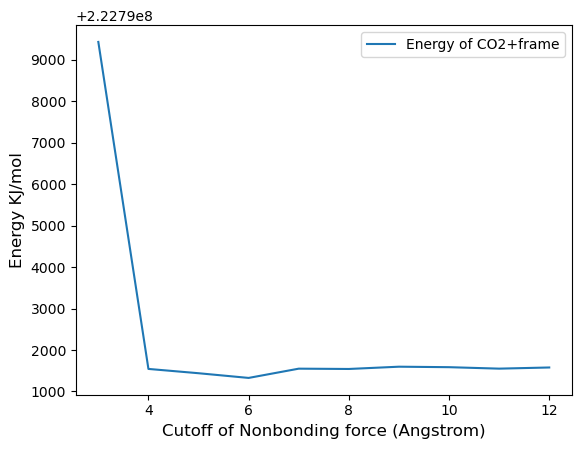

In [101]:
fz = 18
plt.fig = (7,6)

plt.plot(cutoff_arr*10,ls_1,label="Energy of CO2+frame")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

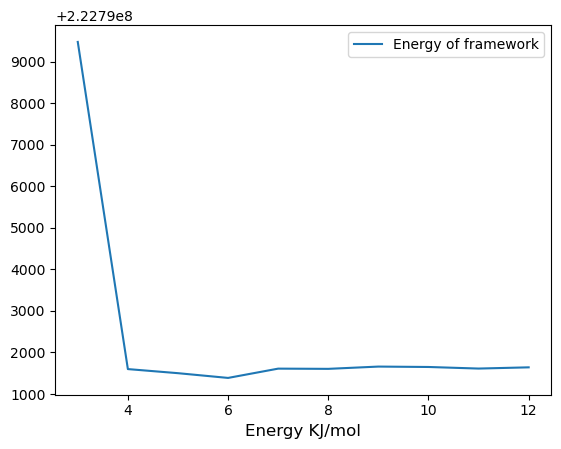

In [98]:
fz = 18
plt.fig = (7,6)

plt.plot(cutoff_arr*10,ls_2,label="Energy of framework")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.xlabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()


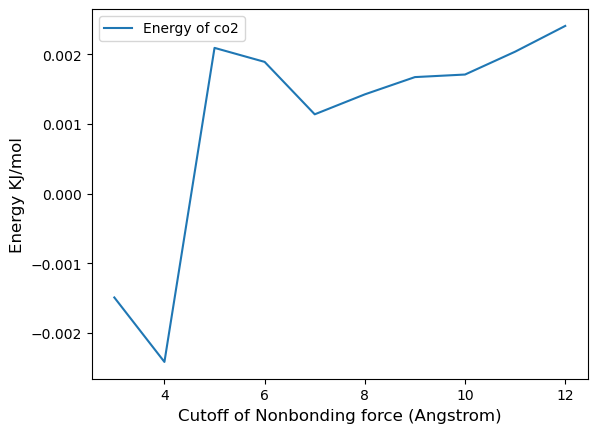

In [97]:
fz = 18
plt.fig = (7,6)

plt.plot(cutoff_arr*10,ls_3,label="Energy of co2")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

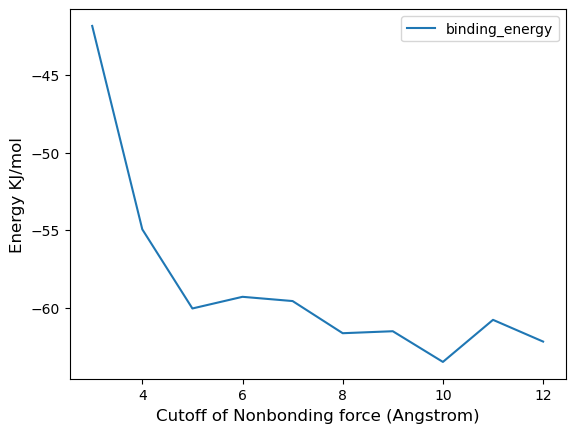

In [102]:
ls_all = [i-j-k for i,j,k in zip(ls_1,ls_2,ls_3)]
plt.plot(cutoff_arr*10,ls_all,label="binding_energy")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

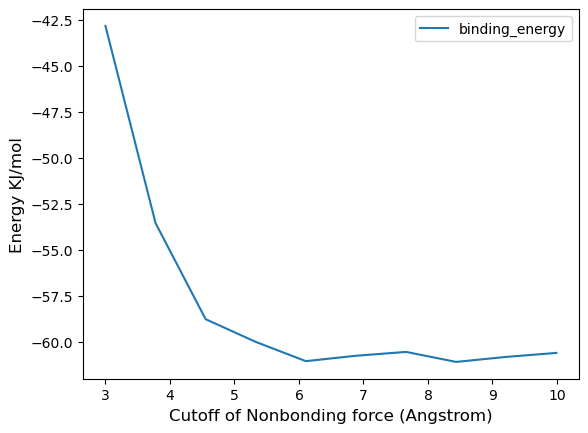

In [108]:

ls_all = [i-j-k for i,j,k in zip(ls_1,ls_2,ls_3)]
plt.plot(cutoff_arr*10,ls_all,label="binding_energy")
plt.xlabel("Cutoff of Nonbonding force (Angstrom)", fontsize=fz-6)
plt.ylabel("Energy KJ/mol", fontsize=fz-6)
plt.legend()

In [3]:
ner_ls = []

positions=initial_positions[:]

topo = pdb.topology
pos = positions[:]
print(len(pos))
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(topo, ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False), integ)
simulation.context.setPositions(pos)
state=simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
print(potential_energy)
ener_ls.append(potential_energy)

topo = frame_top
pos = positions[:40]
print(len(pos))
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(topo, ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False), integ)
simulation.context.setPositions(pos)
state=simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
print(potential_energy)
ener_ls.append(potential_energy)


topo = gas_top
pos = positions[40:]
print(len(pos))
integ = mm.LangevinIntegrator(SET_temperature*unit.kelvin, 1/unit.picosecond, 2.5*unit.femtosecond)
simulation = app.Simulation(topo, ff.createSystem(topo, nonbondedMethod=app.PME, nonbondedCutoff=0.356*unit.nanometer, constraints=None, removeCMMotion=False), integ)
simulation.context.setPositions(pos)
state=simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy().in_units_of(unit.kilojoules_per_mole)
print(potential_energy)
ener_ls.append(potential_energy)

print("This is interaction energy: ", ener_ls[0]-ener_ls[1]-ener_ls[2])